## **Notebook Imports**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import tensorflow as tf

import optuna

## **Importing Data**

In [4]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
target = train['Survived'].astype(int)
test_ids = test['PassengerId']

In [7]:
train1 = train.drop(['PassengerId', 'Survived'], axis= 1)
test1 = test.drop('PassengerId', axis=1)

In [8]:
data1 = pd.concat([train1, test1], axis= 0).reset_index(drop= True)
data1.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
data1.isna().sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [10]:
data1.drop(['Name', 'Ticket', 'Cabin'], axis= 1, inplace= True)

In [11]:
data1.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


## **EDA**

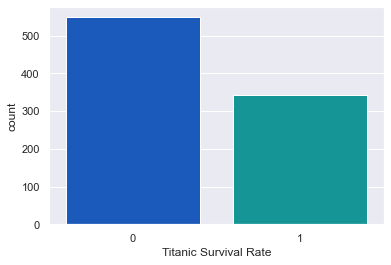

In [12]:
sns.countplot(x = target, palette= 'winter')
plt.xlabel('Titanic Survival Rate');

So, it's clear from the above plot that majority of the people onboarding the titanic did not survived.

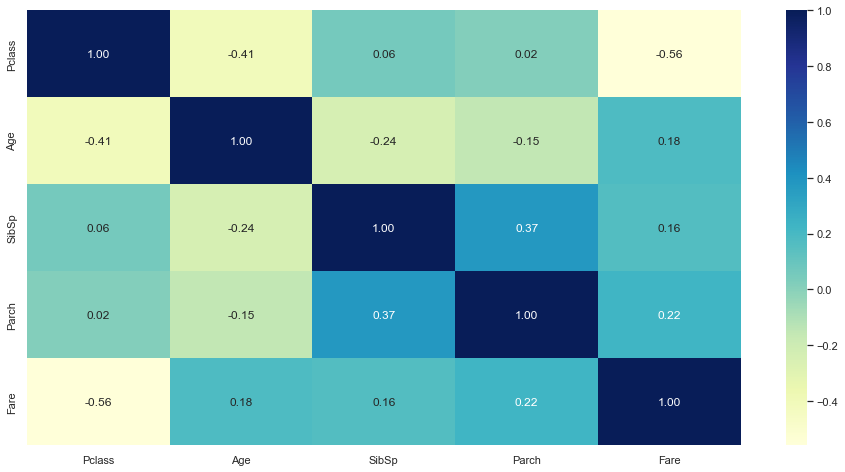

In [13]:
plt.figure(figsize= (16, 8))
sns.heatmap(data1.corr(), annot = True, cmap= 'YlGnBu', fmt= '.2f');

It seems like most of our independent varaibles are not correlated except `SibSp` and `Parch`. We will deal with that while doing feature engineering

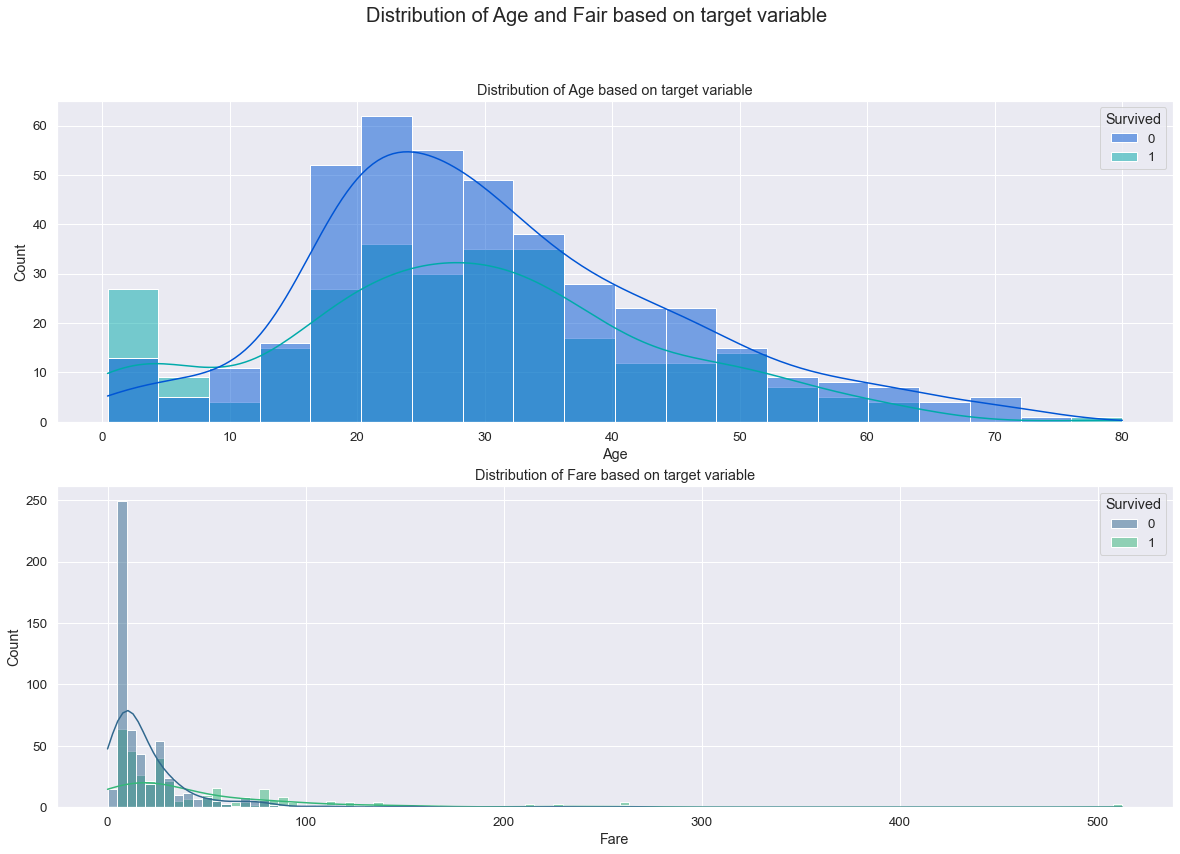

In [14]:
sns.set_context('notebook', font_scale= 1.2)
fig, ax = plt.subplots(2, figsize = (20, 13))

plt.suptitle('Distribution of Age and Fair based on target variable', fontsize = 20)

# I am using the training dataset only to plot these as we don't have target variable in our test dataset
ax1 = sns.histplot(x ='Age', data= train, hue= 'Survived', kde= True, ax= ax[0], palette= 'winter')
ax1.set(xlabel = 'Age', title= 'Distribution of Age based on target variable')

ax2 = sns.histplot(x ='Fare', data= train, hue= 'Survived', kde= True, ax= ax[1], palette= 'viridis')
ax2.set(xlabel = 'Fare', title= 'Distribution of Fare based on target variable')

plt.show()

It is evident from the plot that children did tend to have more chances of survival as compared to older individuals


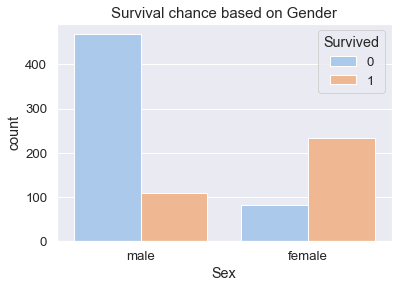

In [15]:
sns.countplot(x = 'Sex', data= train, hue= 'Survived', palette= 'pastel')
plt.title('Survival chance based on Gender', fontsize = 15);

Now that's a clear pattern here. It seems like females were 3 times more likely to survive as compared to males.

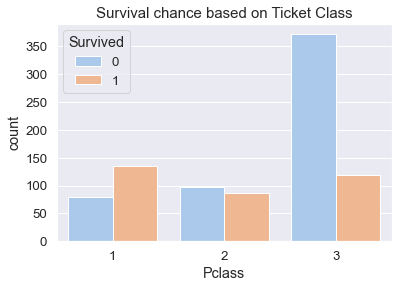

In [16]:
sns.countplot(x = 'Pclass', data= train, hue= 'Survived', palette= 'pastel')
plt.title('Survival chance based on Ticket Class', fontsize = 15);

We can also conclude that people travelling in 3rd class were less likely to survive as compared to people travelling in first class


## **Filling Missing Values**

In [17]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

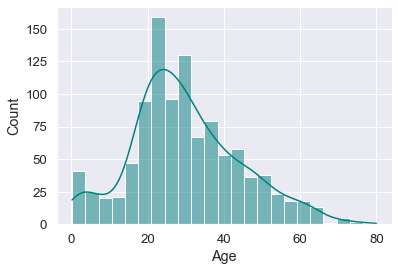

In [18]:
sns.histplot(data1['Age'], color= 'teal', kde= True);

In [19]:
data2 = knn_impute(data1, 'Age')

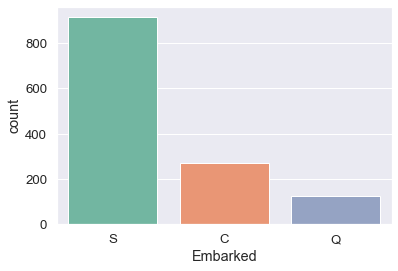

In [20]:
sns.countplot(x = data2['Embarked'], palette= 'Set2');

Majority of the people embarked from Southampton, so we will just fill the missing values in Embarked column with `S`

In [21]:
data2['Embarked'].fillna('S', inplace= True)

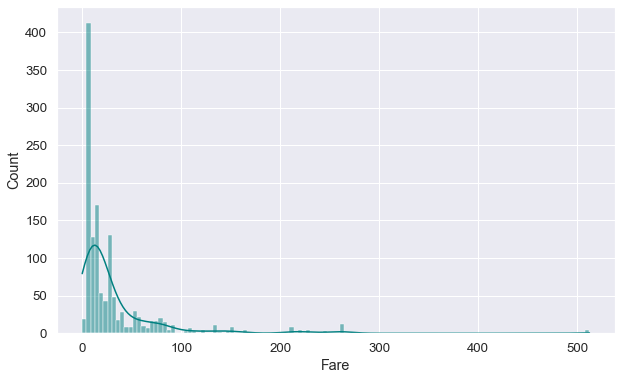

In [22]:
plt.figure(figsize= (10, 6))
sns.histplot(data2['Fare'], color= 'Teal', kde= True);

Distribution of `Fare` is clearly skewed, therefore we will just fill the only missing value we have in this column with median

In [23]:
data2['Fare'].fillna(data1['Fare'].median(), inplace= True)

In [24]:
data2.isna().sum()


Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

We don't have any more missing values in the dataset. Let's now move on to Encoding our categorical variables

### Hacktoberfest - good first issue

Adding a new feature, age bucket, in which the if the age is between 0 - 30 then it will be given a score of 2 since the people with age between 0-30 have more chances of surviving. Similarly with age between 30-60 it will be given a score of 1 and rest will be given a score of 0.

In [25]:
data3 = data2.copy()

In [26]:
data3.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [27]:
#  generally the people with age group between 0 - 40 are more likely to survive
def get_bucket(age):
    if age > 60:
        return 0
    if age > 30:
        return 1
    return 2
data3['age bucket'] = data3['Age'].apply(get_bucket)

In [28]:
data3.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,age bucket
0,3,male,22.0,1,0,7.2500,S,2
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,2
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,1


## **Encoding**

In [29]:
data3 = data2.copy()
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Sex       1309 non-null   object 
 2   Age       1309 non-null   float64
 3   SibSp     1309 non-null   int64  
 4   Parch     1309 non-null   int64  
 5   Fare      1309 non-null   float64
 6   Embarked  1309 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 71.7+ KB


In [30]:
data3 = pd.get_dummies(data3)

In [31]:
data3.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


## **Scaling**

In [32]:
sc = StandardScaler()
data3[['Age', 'Fare']] = sc.fit_transform(data3[['Age', 'Fare']])


In [33]:
data3.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,-0.510002,1,0,-0.503291,0,1,0,0,1
1,1,0.678017,1,0,0.734744,1,0,1,0,0
2,3,-0.212997,0,0,-0.490240,1,0,0,0,1
3,1,0.455263,1,0,0.383183,1,0,0,0,1
4,3,0.455263,0,0,-0.487824,0,1,0,0,1


## **Feature Enginerring**

Both the `SibSp` and `Parch` column suggests whether the person was person was travelling with his family or not. So we will convert these features into a single feature called family

In [34]:
data3['Family'] = np.where(data3['SibSp'] + data3['Parch'] > 0, 1, 0)
data3.drop(['SibSp', 'Parch'], axis= 1, inplace= True)

In [35]:
data3.head()

,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Family
0,3,-0.510002,-0.503291,0,1,0,0,1,1
1,1,0.678017,0.734744,1,0,1,0,0,1
2,3,-0.212997,-0.490240,1,0,0,0,1,0
3,1,0.455263,0.383183,1,0,0,0,1,1
4,3,0.455263,-0.487824,0,1,0,0,1,0


In [36]:
train_final = data3.loc[:train.index.max(), :].copy()
test_final = data3.loc[train.index.max() + 1:, :].reset_index(drop=True).copy()


## **Modelling**

In [37]:
models = {
    'xgboost' : XGBClassifier(),
    'catboost' : CatBoostClassifier(verbose=0),
    'lightgbm' : LGBMClassifier(),
    'gradient boosing' : GradientBoostingClassifier(),
    'random forest' : RandomForestClassifier(),
    'logistic regression': LogisticRegression(),
    'naive bayes': GaussianNB(),
}

In [38]:
target = target.astype(int)

In [39]:
for name, model in models.items():
    model.fit(train_final, target)
    print(f'{name} trained')

xgboost trained
catboost trained
lightgbm trained
gradient boosing trained
random forest trained
logistic regression trained
naive bayes trained


## **Evaluation**

In [40]:
results = {}

kf = KFold(n_splits= 10)

for name, model in models.items():
    result = cross_val_score(model, train_final, target, scoring = 'roc_auc', cv= kf)
    results[name] = np.mean(result)

In [41]:
for name, result in results.items():
    print("-------\n" + name)
    print(f'ROC score: {round(result, 3)}')

-------
xgboost
ROC score: 0.862
-------
catboost
ROC score: 0.873
-------
lightgbm
ROC score: 0.867
-------
gradient boosing
ROC score: 0.865
-------
random forest
ROC score: 0.858
-------
logistic regression
ROC score: 0.843
-------
naive bayes
ROC score: 0.815


In [43]:
results_df = pd.DataFrame(results, index=range(0,1)).T.rename(columns={0: 'ROC Score'}).sort_values('ROC Score', ascending=False)
results_df

,ROC Score
catboost,0.872516
lightgbm,0.867494
gradient boosing,0.864926
xgboost,0.862251
random forest,0.858137
logistic regression,0.842527
naive bayes,0.814845


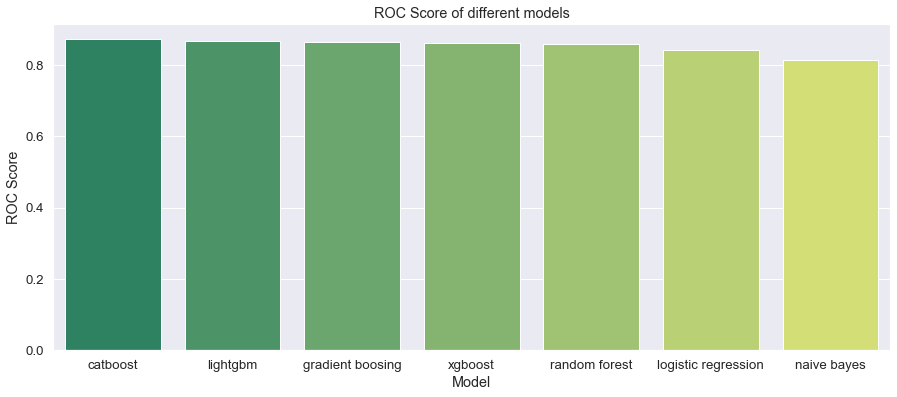

In [44]:
plt.figure(figsize = (15, 6))
sns.barplot(x= results_df.index, y = results_df['ROC Score'], palette = 'summer')
plt.xlabel('Model')
plt.ylabel('ROC Score')
plt.title('ROC Score of different models');

#### Clearly, catboost had the best ROC Score, lets do some hyperparameter optimization and make the final predictions based on it

## **Hyperparamer Optimization**

In [45]:
# def catboost_objective(trial):
#     learning_rate = trial.suggest_float('learning_rate', 0, 0.5)
#     depth = trial.suggest_int('depth', 3, 10)
#     n_estimators = trial.suggest_int('n_estimators', 50, 600)
    
#     model = CatBoostClassifier(
#         learning_rate= learning_rate,
#         depth= depth,
#         n_estimators= n_estimators,
#         verbose= 0
#     )

#     model.fit(train_final, target)
#     cv_score = cross_val_score(model, train_final, target, scoring= 'roc_auc', cv= kf)

#     return np.mean(cv_score)

# study = optuna.create_study(direction= 'maximize')
# study.optimize(catboost_objective, n_trials= 100)

In [46]:
catboost_params = {
    'learning_rate': 0.1682046368673911, 
     'depth': 6, 
     'n_estimators': 540,
     'verbose':0
}

In [47]:
cb = CatBoostClassifier(**catboost_params)
cb.fit(train_final, target)
pred_cb = cb.predict(test_final)

## **ANN**

In [48]:
train_final.shape

(891, 9)

In [49]:
train_final = np.asarray(train_final).astype(np.float32)
test_final = np.asarray(test_final).astype(np.float32)
target = np.asarray(target).astype(np.float32)

In [50]:
model = tf.keras.Sequential([
    tf.keras.Input(9),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss = 'binary_crossentropy',
    metrics = [tf.keras.metrics.AUC(name='auc')]
)

EPOCHS = 100

history = model.fit(train_final, target, validation_split = 0.20, epochs = EPOCHS)

Epoch 1/100
23/23 [==============================] - 1s 12ms/step - loss: 0.6658 - auc: 0.6015 - val_loss: 0.6464 - val_auc: 0.6662
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6433 - auc: 0.7585 - val_loss: 0.6204 - val_auc: 0.7879
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6244 - auc: 0.8163 - val_loss: 0.5988 - val_auc: 0.8318
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6084 - auc: 0.8292 - val_loss: 0.5796 - val_auc: 0.8478
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5942 - auc: 0.8320 - val_loss: 0.5631 - val_auc: 0.8618
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5805 - auc: 0.8380 - val_loss: 0.5460 - val_auc: 0.8685
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5679 - auc: 0.8355 - val_loss: 0.5312 - val_auc: 0.8695
Epoch 8/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5557 - 

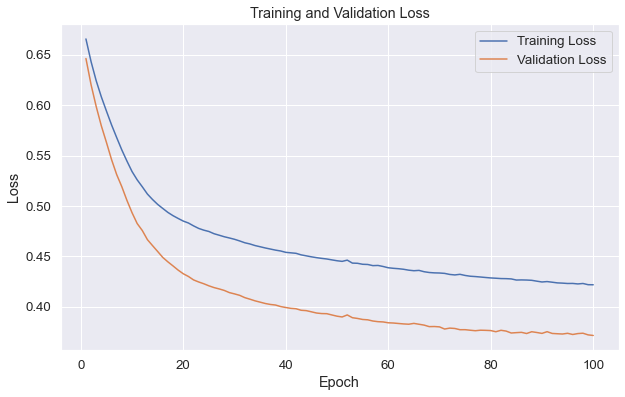

In [51]:
plt.figure(figsize=(10, 6))

epochs = range(1, EPOCHS + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Clearly our ANN is doing a better job in classifying our target column

In [52]:
pred_ann = model.predict(test_final)

In [53]:
submission = pd.DataFrame(test_ids, index= None)

In [54]:
submission['Survived'] = pred_ann

In [55]:
submission['Survived'] = submission['Survived'].apply(lambda x: 1 if x>0.5 else 0)

In [56]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [57]:
submission.to_csv('submission.csv', index= None)